In [1]:
experiment_setup_name = "musicians_category_small_net_10_sample_batch_adadelta"

In [2]:
import sys
sys.path.append("..")

In [3]:
#import everything in the world
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import theano
theano.config.floatX = 'float32'
theano.config.openmp = True
import theano.tensor as T
import lasagne
%load_ext autoreload
%autoreload 2
import pandas as pd
!mkdir ~/agentnet_snapshots


Couldn't import dot_parser, loading of dot files will not be possible.
mkdir: cannot create directory '/root/agentnet_snapshots': File exists


In [4]:
floatX = theano.config.floatX

from auxilary import _shared,set_shared,_in1d
from persistence import save,load


# Эта тетрадка рассказывает нелёгком пути обучения
* Recurrent Q-network 
* 1000 нейронов
* с epsilon-greedy обучением
* Adadelta


Много вспомогательного кода

# Постановка задачи
* В начале сетке даётся некоторый человек, про которого она пока ничего не знает
* Человек - музыкант или околомузыкальная личность (с меньшей вероятностью - группа или... страна)
* Про человека известен некоторый набор фактов
 * факты типа "Известно, что" - за то, что какой-то аттрибут есть в его вики-карточке
   * например Nickname:is_known - есть прозвище, Died:is_known - есть дата смерти
 * Категориальные факты
   * инструменты, на которых играет человек
   * происхождение
   * декады активности
   * и т.п.


* За один шаг сетка может
 * сказать, что какой-то аттрибут про пользователя есть
   * например, Nickname:is_known - предположение, что у пользователя есть прозвище
   * если догадка верна, сеть получает положительное подкрепление ("конфетку")
   * если нет - отрицательное ("подзатыльник")
 * сказать "больше ничего не угадаю, несите следующего"
   * нулевое подкрепление
   * случайно выбирается следующий пользователь
  

# данные
* Всего в выборке 434 аттрибута
 * примеры аттрибутов в табе ниже
* В данном случае сеть обучается на чуть менее, чем 2500 случайных людей
* всего в выборке почти 100к людей/групп/всякого трэша

In [5]:
#вгрузим данные про кучу музыкантов 
#как оно собирается - ./data/preprocessing.ipynb
import pandas as pd
df = pd.DataFrame.from_csv("../data/musicians_categorized.csv")

0.0346481118134
(22612, 393)


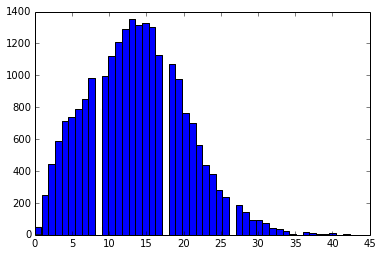

In [6]:
#гистограмма количества аттрибутов известных про музыканта
plt.hist((df.values).sum(axis=1),bins=50)
print (df.values).mean()
print df.shape

In [7]:
#отрежем тех, про кого известно менее 5 аттрибутов
df =  df[df.values.sum(axis=1) > 15]
print "всего самплов", df.shape

всего самплов (8594, 393)


In [8]:
from sklearn.cross_validation import train_test_split

In [9]:
#split categories and attributes
feature_names = df.columns
categorical_columns = np.nonzero(map(lambda s: s.startswith("category:"),feature_names))[0]
attribute_columns = np.nonzero(map(lambda s: not s.startswith("category:"),feature_names))[0]

data_cats = df.iloc[:,categorical_columns]
data_attrs = df.iloc[:,attribute_columns]



In [10]:
#поделим выборку
train_cats,test_cats,train_attrs,test_attrs = train_test_split(data_cats,data_attrs,test_size=0.99,random_state=42)
print "обучающая выборка:" ,len(train_attrs)
print "контрольная выборка:", len(test_attrs)

обучающая выборка: 85
контрольная выборка: 8509


# problem definition

Обучатор состоит из 2 частей
* "среды обучения"
* определятора полезностей
* самой нейронки

Среда обучения - такая штука, которая 
* подсовывает нейронке людей, 
 * каждый раз выбирается случайное подмножество людей 
   * (можно и 100 и 10 - просто не успел сравнить)
   * возвращает ответы на действия нейронки, попутно обновляя своё состояние
Определятор полезностей
* умеет считать полезность каждого действия по паре "состояние СРЕДЫ, действие агента ИЗ этого состояния"
* имеет функции для быстрого определения наград за все действия в сессиях

Нейронка будет далее по списку


__***для простоты, CategoryGuess будет имплементировать И среду И награждатор (см. класс ниже)***__

In [11]:
from objective import BaseObjective
from environment import BaseEnvironment

class CategoryGuess(BaseObjective,BaseEnvironment):
    def __init__(self,n_attrs,n_categories,batch_size=10):
        self._attributes = _shared("X_attrs_data",np.zeros([batch_size,n_attrs]),'uint8')
        self._categories =  _shared("categories_data",np.zeros([batch_size,n_categories]),'uint8')
        self._batch_size = _shared("batch_size_scalar",batch_size,'int32')
        
        _end_action = T.zeros([self._batch_size,1], dtype='uint8')
        
        self._joint_data = T.concatenate([self._attributes,
                                          self._categories,
                                          _end_action,
                                         ],axis=1).astype('float32')
    
        #indices
        self._category_action_ids = T.arange(
            self._attributes.shape[1],
            self._attributes.shape[1]+self._categories.shape[1]
        )
        
        self._end_action_id = self._joint_data.shape[1]-1
    def load_data_batch(self,attrs_batch,categories_batch):
        attrs_batch = np.array(attrs_batch)
        categories_batch = np.array(categories_batch)
        set_shared(self._attributes,attrs_batch)
        set_shared(self._categories,categories_batch)
        set_shared(self._batch_size,attrs_batch.shape[0])

    @property
    def n_actions(self):
        return int(self._joint_data.shape[1].eval())
    @property
    def observation_size(self):
        return int((self._joint_data.shape[1]+1).eval())
    @property
    def state_size(self):
        return int(self._joint_data.shape[1].eval())
    @property
    def batch_size(self):
        return int(self._batch_size.get_value())
    

    
    def get_first_state(self,batch_size=1):
        assert batch_size == self._joint_data.shape[0].eval()
        return T.zeros_like(self._joint_data,dtype='uint8') 
    
    
    def get_output_and_observation(self,last_state,action):
        
        #state is a boolean vector: whether or not i-th action
        #was tried already during this session
        #last output[:,end_code] always remains 1 after first being triggered
        
        
        batch_range = T.arange(action.shape[0])

        can_do_action = T.eq(last_state[:,self._end_action_id],0)
        
        state_after_action = T.set_subtensor(last_state[batch_range,action],1)
        
        new_state = T.switch(
            can_do_action.reshape([-1,1]),
            state_after_action,
            last_state
        )
        
        
        
        observation = T.concatenate([
                self._joint_data[batch_range,action,None],#uint8[batch,1]
                T.extra_ops.to_one_hot(action,self._joint_data.shape[1]),
            ],axis=1)
        
        return new_state, observation

    def get_reward(self,batch_i,session_states,session_actions):
        """
        WARNING! this runs on a single session, not on a batch
        reward given for taking the action in current environment state
        arguments:
            session_states float[batch_id, memory_id]: environment state before taking action
            session_actions int[batch_id]: agent action at this tick
        returns:
            reward float[batch_id]: reward for taking action from the given state
        """
        time_range = T.arange(session_actions.shape[0])
        

        _has_tried_already = session_states[time_range,session_actions]
        _session_is_active = T.eq(session_states[:,self._end_action_id],0)
        _has_finished_now = T.eq(session_actions,self._end_action_id)
        _action_is_categorical = _in1d(session_actions, self._category_action_ids)
        
        _response = self._joint_data[batch_i,session_actions].ravel()
        
        #categorical and attributes
        _reward_for_intermediate_action = T.switch(
            _action_is_categorical,
            _response*4-2,
            _response*2-1
        )
        #include end action
        _reward_for_action = T.switch(
            _has_finished_now,
            0,
            _reward_for_intermediate_action,
        )
        
        _reward_if_first_time = T.switch(
                _has_tried_already,
                0,
                _reward_for_action,
            )
        
        _final_reward = T.switch(
            _session_is_active,
            _reward_if_first_time,
            0,

            
        )
        
        
        return _final_reward.astype(floatX)

In [12]:
env = CategoryGuess(train_attrs.shape[1],train_cats.shape[1],5)

# agent setup
В свою очередь, нейронка состоит из 3 частей
* память агента
    * на вход получает пару (предыдущее состояние памятиа агента, сенсорная инфа о среде на ЭТОМ шагу)
    * определяет текущее состояние памяти агента (на том же шагу, что и сенсорная инф-ция со входа)
    * тут - GRUlayer, в потенциале - вообще что угодно, хоть 10 шагов LSTM за 1 раз
       * какой именно GRUlayer:
       * Reset gate - dense w/ expit
       * Update gate - dense w/ expit
       * Hidden update gate - dense w/ tanh

* определятор Q-значений
    * на вход получает память агента
    * определяет Q_значения каждого действия
    * тут - DenseLayer, потенциал - что угодно
* приниматор решений по Q-значениям
    * на вход получает Q-значения для действий
    * определяет, как вывод нейронки трансформируется в решение,
    * формат выхода - целые числа - номера выбранных действий
     * тут - с вероятностью epsilon берётся решение, 
       * которому предсказана наибольшая полезность
       * иначе берётся случайное равновероятное
     * альтернативный вариант - решения выбираются с веростностями
       * $Pi(a) = softmax(Qi(a)) = {e^{Qi(x)}} / {\sum\limits_{j=1}^n e^{Qj(X)}}$ 
       * где Q(a) - предсказанная полезность действия a
* всё это делается векторизованно для батча произвольной размерности


### Agent - просто обёртка над этими 3 пунктами
* строго говоря, можно воткнуть любую нейронку, которая мапает 
* `float last_agent_state[batch,units], float observation[batch,sensors] ->`
* `-> float new_agent_state[batch,units], float qvalues[batch,actions], int actions[batch]`


In [13]:
from resolver import EpsilonGreedyResolver
from memory import GRUMemoryLayer
from agent import Agent

In [14]:
import lasagne

n_hid=100


_observation_layer = lasagne.layers.InputLayer([None,env.observation_size],name="obs_input")
_prev_state_layer = lasagne.layers.InputLayer([None,n_hid],name="prev_state_input")
#memory
gru = GRUMemoryLayer(n_hid,
                     _observation_layer,
                     _prev_state_layer,
                     name="gru0")

#q_eval
q_eval = lasagne.layers.DenseLayer(gru,num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")
#resolver
epsilon = _shared("e-greedy.epsilon",0.9,dtype=floatX)

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")


#all together
agent = Agent(gru,q_eval,resolver)


In [15]:
history = agent.get_sessions(env,session_length=20,
                       batch_size=env._joint_data.shape[0],
                       initial_env_state=env.get_first_state(env.batch_size))
state_seq,observation_seq,hidden_seq,qvalues_seq,action_seq = history

rewards_seq = env.get_reward_sequences(state_seq,action_seq)


In [16]:
get_history = theano.function([],history+(rewards_seq,),mode=theano.compile.mode.FAST_RUN)



# weights
* вот так нахаляву можно вытащить ВСЕ веса нейронок агента
* что НЕ вытаскивается 
 * архитектура сети
 * гиперпараметры (жадность, gamma)
 * состояния среды/наблюдения
* короче, вытаскиваются только "нейронячие" параметры
* хочешь, чтобы в твоём слое вытащилась какая-то shared переменная - добавь её в параметры слоя [с каким-ть тэгом, если хочешь]
* всё как в ванильной лазанье

In [17]:
#all trainable weights
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

In [18]:
#all weights but for Qvalues prediciton ones (not to penalize q-predictors by l2)
weights_inner = filter(lambda w: "QEvaluator" not in w.name,weights)
weights_inner

[gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update]

# целевая функция для обучения сети

* Интуитивно, цель - предсказывать Q-значения (полезности) действий
* $Q(s,a) = R(s,a) + gamma* Max_{a'}{ Q(s',a')}  $
 * R(s,a) - непосредственная награда за действие (+5 если угадал, -1 если нет и т.п.)
 * s' - состояние, в которое агент попал, сделав действие a из состояния s
 * a' - действие, которое можно совершить в состоянии s'
 * gamma - во сколько раз награда/пинок через 1 шаг менее значимы, чем сейчас
 * интуиция - "в состоянии s полезность действия a - это непосредственная печенька за это действие ПЛЮС все печеньки, которые можно собрать, если после этого действия вести себя оптимально"
 
* В реальном мире оптимизируются попарно 2 приближения этой функции
* $ RMSE_{reccurent}: (NN_s(a) - (R + gamma* Max_a'{ NN_s'(a')})^2$
 * NN_s(a) предсказаннная из состояния s полезност Q(s,a)
 * считается для тех NN_s(a), которые агент совершил
 * NN_s'(a') - полезности всех действий сразу после совершения a из состяния s

* $ RMSE_{naive}: (NN_s(a^*) - (R + gamma*  NN_s'(a'^*))^2$
 * аналогично предыдущему, но a* - реально совершённое агентом действие
 * оценка смещена, но куда проще оптимизируется, чем предыдущая
   * по крайней мере, с softmax принятием решений

In [19]:
is_alive_seq = T.eq(state_seq[:,:,-1],0)

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = _shared('q_learning_gamma',np.float32(0.95),floatX)


ref_tuples = env.get_reference_tuples(qvalues_seq,action_seq,rewards_seq,is_alive_seq,gamma_or_gammas=gamma,)

action_ids_ravel,immediate_rewards_ravel, predicted_Qvalues_ravel,reference_Qvalues_ravel,is_end_ravel= ref_tuples

from auxilary import consider_constant
reference_Qvalues_ravel = consider_constant(reference_Qvalues_ravel)

predicted_Qvalues_for_actions_ravel = predicted_Qvalues_ravel[T.arange(action_ids_ravel.shape[0]),action_ids_ravel]


In [20]:
loss_recurrent = lasagne.objectives.squared_error(reference_Qvalues_ravel,predicted_Qvalues_for_actions_ravel).mean()

In [21]:
weight_ravel = T.concatenate([w.ravel() for w in weights_inner])
reg_l2 = reg_l2 = T.mean(weight_ravel**2)*0.1


In [22]:
loss = loss_recurrent + reg_l2

# алгоритм обучения
* обучаются все параметры обычным Stochastic Gradient Descent с Nestrov Mommentum
* регуляризации нет, ибо пока не понадобилась

In [23]:
_updates = lasagne.updates.adadelta(loss,
                                             weights,learning_rate=0.05)
#updates = lasagne.updates.sgd(loss_recurrent,weights,0.1)

In [24]:
mean_session_reward = immediate_rewards_ravel.sum()/ rewards_seq.shape[0]
train_fun = theano.function([],[loss,loss_recurrent,reg_l2,mean_session_reward],updates=_updates)
loss_fun = theano.function([],[loss,loss_recurrent,reg_l2,mean_session_reward])

# evaluation
* удобная [мне одному] функция, которая показывает примеры сессий и внутреннее состояние нейронки
* текстовая часть - 
    * #(номер_действия) (имя_действия) (предсказанное_Qvalue) -> (награда) | следующая итерация
* картинка (если display = True)
    * X - моменты времени, Y - попугаи
    * жЫрные линии - Q-значения категорий
    * тонкие линии - Q-значения узнавания аттрибутов
    * точки на линиях - выбранные действия
    * пунктирные линии - активация нейронов в памяти агента
    * синяя черта (тонкая, вертикальная) - конец сессии (действие или лимит времени)


In [25]:
evaluation_fun = theano.function([],[action_ids_ravel,predicted_Qvalues_for_actions_ravel,immediate_rewards_ravel,
                                     reference_Qvalues_ravel,is_end_ravel,
                                     hidden_seq,qvalues_seq,action_seq])


In [26]:
#new names order
feature_names = list(data_attrs.columns) + list(data_cats.columns) + ["<end_session_action>"]
is_categorical = lambda i: feature_names[i].startswith("category:")

def print_session(n_sessions = 3,display=False,legend=True):
    
    a_lot_of_data = evaluation_fun()    
    actions,qvalues,rewards,ref_qvalues,end_sel = a_lot_of_data[:5]
    hidden_log,qvalues_log,action_log = a_lot_of_data[5:]
    
    
    
    b_i = 0 #batch iter ~ session iter
    t_i = 0 #time iter
    

    for a,q,r,q_ref,is_end in zip(actions,qvalues,rewards,ref_qvalues,end_sel):
        print "#%i: %s (%.3f) -> %s |"%(a,feature_names[a],q, r,),
        
        
        t_i +=1
        if is_end ==1:
            
            print '<end>'
            print 'true:',
            for cat in env._categories.get_value()[b_i].nonzero()[0]:
                print feature_names[cat+env._attributes.shape[1].eval()],
            print
                
            #plot qvalues
            if display:
                plt.figure(figsize=[16,8])

                q_values = qvalues_log[b_i].T
                for i in range(q_values.shape[0]):
                    plt.plot(q_values[i],label=feature_names[i],linewidth = 1 + 4*is_categorical(i))

                hidden_activity =  hidden_log[b_i].T
                for i, hh in enumerate(hidden_activity):
                    plt.plot(hh,'--',label='n'+str(i))
                    
                session_actions = action_log[b_i,:t_i]
                action_range = np.arange(len(session_actions))
                plt.scatter(action_range, qvalues_log[b_i][action_range, session_actions])


                #session end
                plt.plot(np.repeat(t_i-1,2),np.linspace(-0.5,0.5,2))
                plt.xlim(0,max(t_i*1.1,2))
                plt.xticks(np.arange(t_i))
                plt.grid()
                if legend:
                    plt.legend()
                plt.show()
                
            print
            #/
            b_i +=1
            t_i = 0

            if b_i >= n_sessions:
                break


# training

In [27]:
def load_random_batch(env,attrs,cats,batch_size=10):
    
    attrs,cats = np.array(attrs),np.array(cats)
    
    assert len(attrs) == len(cats)
    batch_ids = np.random.randint(0,len(attrs),batch_size)
    env.load_data_batch(attrs[batch_ids],cats[batch_ids])

In [28]:
from collections import defaultdict

epoch_counter = 1
score_log = defaultdict(dict) #{metric_name: {epoch:value} }

def plot_scores(title="metrics"):
    plt.figure(figsize=[10,10])
    plt.title("metrics history")
    for metric_name, metric_dict in score_log.items():            
        plt.plot(*zip(*sorted(metric_dict.items())),label = metric_name)

    plt.title(title)
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
alpha = 0.1
ma_reward = 0.
ma_reward_greedy = 0.

# само обучение
* шаг алгоритма - 
 * выбрать B случайных людей
 * пересчитать "жадность" алгоритма (чем дальше, тем более жадный)
 * сделать шаг обучения
 * раз в M итераций - добавить точку на график обучения по 3 метрикам
   * ожидание награды за сессию при текущей жадности на тренировочных данных
   * то же самое при максимальной жадности
 * раз в N итераций - 
   * показать несколько примеров сессий на обучающих данных при разной жадности
   * показать графики обучения
 * раз в K итераций - записать веса нейронки в файл (snapshot)

epoch 100,loss 1.41817, greed 0.20180, rewards: ( train -20.94740, det_train 0.00000) 
rec 1.417 reg 0.001
epoch 200,loss 1.27608, greed 0.20359, rewards: ( train -18.51550, det_train -1.55000) 
rec 1.275 reg 0.001
epoch 300,loss 1.10787, greed 0.20538, rewards: ( train -15.97194, det_train -1.56500) 
rec 1.107 reg 0.001
epoch 400,loss 0.77265, greed 0.20717, rewards: ( train -16.00105, det_train -1.22850) 
rec 0.772 reg 0.001
epoch 500,loss 0.46212, greed 0.20896, rewards: ( train -16.08469, det_train -1.02565) 
rec 0.461 reg 0.001
epoch 600,loss 0.43064, greed 0.21074, rewards: ( train -16.28275, det_train -0.84309) 
rec 0.430 reg 0.001
epoch 700,loss 0.41722, greed 0.21251, rewards: ( train -15.98998, det_train -0.69878) 
rec 0.416 reg 0.001
epoch 800,loss 0.41349, greed 0.21429, rewards: ( train -16.69677, det_train -0.52890) 
rec 0.412 reg 0.001
epoch 900,loss 0.52144, greed 0.21606, rewards: ( train -15.85756, det_train -0.41601) 
rec 0.520 reg 0.001
Evaluation:

deterministic
#1

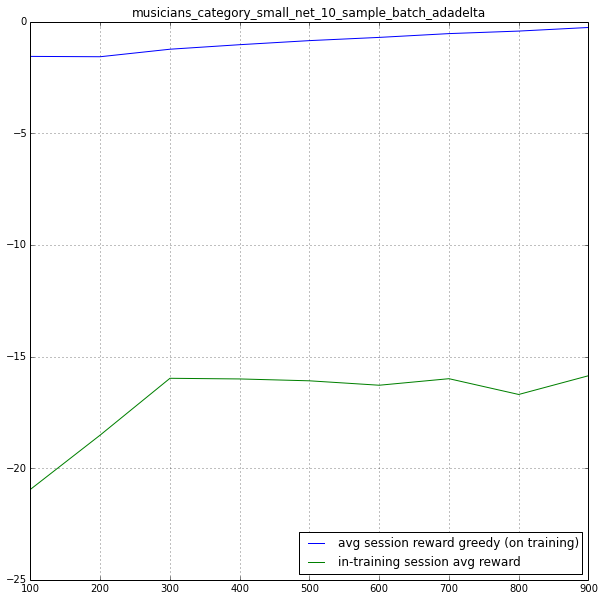

epoch 1000,loss 0.33553, greed 0.21782, rewards: ( train -16.17131, det_train -0.25441) 
rec 0.335 reg 0.001
epoch 1100,loss 0.35285, greed 0.21958, rewards: ( train -15.55571, det_train -0.18897) 
rec 0.352 reg 0.001
epoch 1200,loss 0.59777, greed 0.22134, rewards: ( train -15.86626, det_train -0.05007) 
rec 0.597 reg 0.001
epoch 1300,loss 0.67994, greed 0.22310, rewards: ( train -15.79410, det_train 0.09494) 
rec 0.679 reg 0.001
epoch 1400,loss 0.72163, greed 0.22485, rewards: ( train -15.44825, det_train 0.16544) 
rec 0.721 reg 0.001
epoch 1500,loss 0.89517, greed 0.22660, rewards: ( train -15.19972, det_train 0.29890) 
rec 0.894 reg 0.001
epoch 1600,loss 1.06528, greed 0.22834, rewards: ( train -15.82508, det_train 0.40901) 
rec 1.064 reg 0.001
epoch 1700,loss 1.15466, greed 0.23009, rewards: ( train -14.71829, det_train 0.64811) 
rec 1.154 reg 0.001
epoch 1800,loss 1.20763, greed 0.23182, rewards: ( train -15.34105, det_train 0.82330) 
rec 1.207 reg 0.001
epoch 1900,loss 1.39843, 

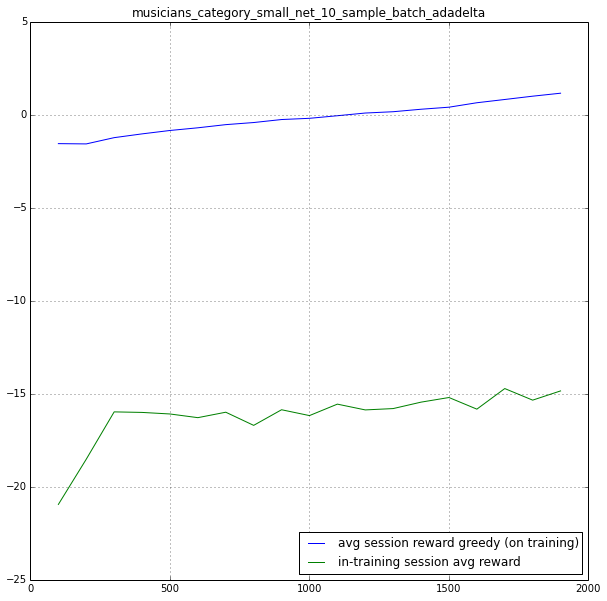

epoch 2000,loss 1.32463, greed 0.23529, rewards: ( train -14.96847, det_train 1.16087) 
rec 1.324 reg 0.001
epoch 2100,loss 1.21813, greed 0.23702, rewards: ( train -14.89786, det_train 1.36478) 
rec 1.217 reg 0.001
epoch 2200,loss 1.04545, greed 0.23874, rewards: ( train -14.76849, det_train 1.52831) 
rec 1.044 reg 0.001
epoch 2300,loss 1.27351, greed 0.24046, rewards: ( train -14.57530, det_train 1.73547) 
rec 1.272 reg 0.001
epoch 2400,loss 1.22733, greed 0.24218, rewards: ( train -15.12449, det_train 2.02193) 
rec 1.226 reg 0.001
epoch 2500,loss 1.55734, greed 0.24389, rewards: ( train -14.69832, det_train 2.03973) 
rec 1.556 reg 0.001
epoch 2600,loss 1.21942, greed 0.24560, rewards: ( train -14.98280, det_train 2.15576) 
rec 1.218 reg 0.001
epoch 2700,loss 0.83509, greed 0.24731, rewards: ( train -14.83153, det_train 2.08018) 
rec 0.834 reg 0.001
epoch 2800,loss 1.02939, greed 0.24901, rewards: ( train -14.92275, det_train 2.09217) 
rec 1.028 reg 0.001
epoch 2900,loss 1.35075, gre

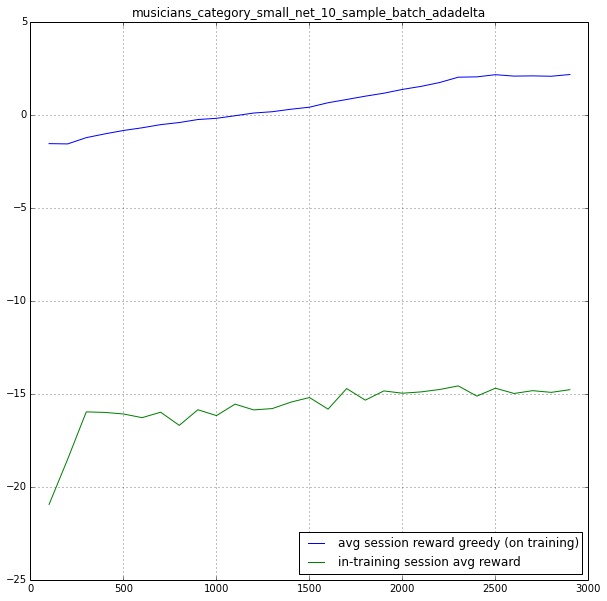

epoch 3000,loss 1.42861, greed 0.25241, rewards: ( train -14.69860, det_train 2.16565) 
rec 1.428 reg 0.001
epoch 3100,loss 1.29902, greed 0.25411, rewards: ( train -14.38143, det_train 2.16909) 
rec 1.298 reg 0.001
epoch 3200,loss 0.75563, greed 0.25580, rewards: ( train -14.27456, det_train 2.27218) 
rec 0.755 reg 0.001
epoch 3300,loss 0.65000, greed 0.25748, rewards: ( train -14.49392, det_train 2.40496) 
rec 0.649 reg 0.001
epoch 3400,loss 0.58940, greed 0.25917, rewards: ( train -14.77904, det_train 2.52447) 
rec 0.588 reg 0.001
epoch 3500,loss 0.77294, greed 0.26085, rewards: ( train -14.31089, det_train 2.62202) 
rec 0.772 reg 0.001
epoch 3600,loss 0.58771, greed 0.26252, rewards: ( train -14.49881, det_train 2.63982) 
rec 0.587 reg 0.001
epoch 3700,loss 0.65618, greed 0.26420, rewards: ( train -14.34786, det_train 2.62584) 
rec 0.655 reg 0.001
epoch 3800,loss 1.07522, greed 0.26587, rewards: ( train -13.96870, det_train 2.52325) 
rec 1.074 reg 0.001
epoch 3900,loss 0.64710, gre

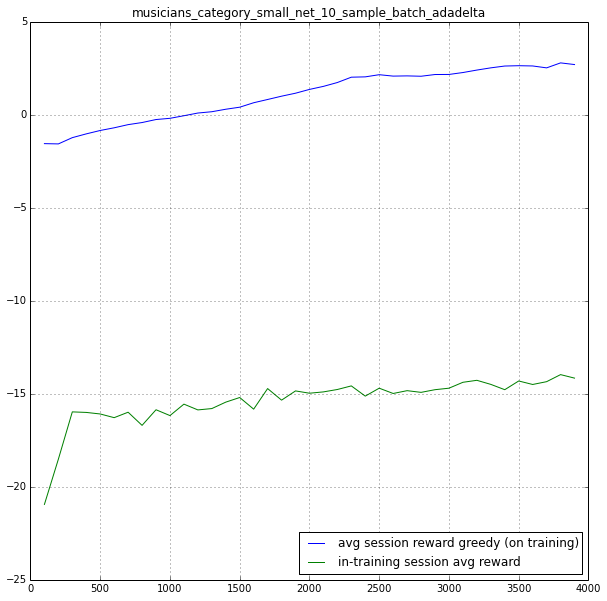

epoch 4000,loss 0.73159, greed 0.26920, rewards: ( train -13.71876, det_train 2.70183) 
rec 0.731 reg 0.001
epoch 4100,loss 0.51880, greed 0.27086, rewards: ( train -13.85120, det_train 2.85165) 
rec 0.518 reg 0.001
epoch 4200,loss 0.87121, greed 0.27251, rewards: ( train -14.01508, det_train 2.80649) 
rec 0.870 reg 0.001
epoch 4300,loss 0.71781, greed 0.27417, rewards: ( train -13.64091, det_train 3.08584) 
rec 0.717 reg 0.001
epoch 4400,loss 0.68557, greed 0.27582, rewards: ( train -14.06538, det_train 3.31725) 
rec 0.685 reg 0.001
epoch 4500,loss 0.50130, greed 0.27746, rewards: ( train -13.66413, det_train 3.20553) 
rec 0.500 reg 0.001
epoch 4600,loss 0.72182, greed 0.27911, rewards: ( train -13.62394, det_train 3.28498) 
rec 0.721 reg 0.001
epoch 4700,loss 0.67105, greed 0.28075, rewards: ( train -13.69557, det_train 3.35648) 
rec 0.670 reg 0.001
epoch 4800,loss 0.43976, greed 0.28238, rewards: ( train -13.74472, det_train 3.42083) 
rec 0.439 reg 0.001
epoch 4900,loss 0.52937, gre

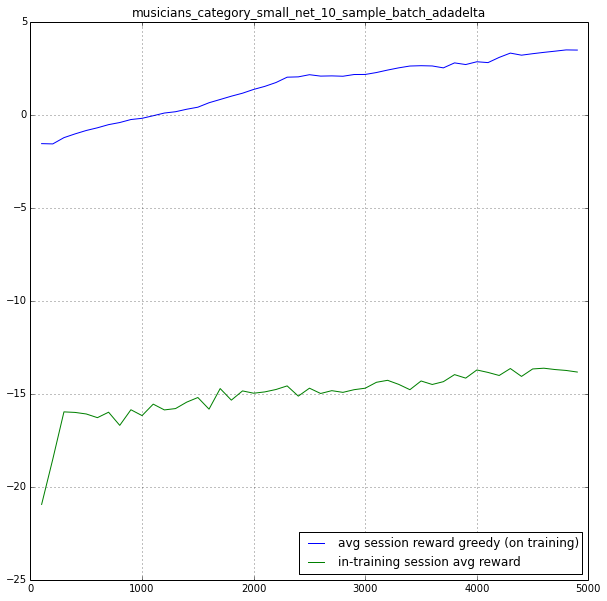

snapshot saved
epoch 5000,loss 0.58977, greed 0.28565, rewards: ( train -13.77951, det_train 3.47987) 
rec 0.589 reg 0.001
epoch 5100,loss 0.50717, greed 0.28727, rewards: ( train -13.54945, det_train 3.48189) 

In [ ]:
n_epochs = 150000
batch_size=10
for i in range(n_epochs):
    
    resolver.rng.seed(epoch_counter)
    
    creeping_greed = min(0.1 + (1.-np.exp(-epoch_counter/50000.)*0.9),0.95)
    creeping_epsilon = 1.-creeping_greed
    
    
    #train
    load_random_batch(env,train_attrs,train_cats,batch_size=batch_size)
    
    loss,q_loss,reg_loss,avg_reward = train_fun()
    
    
    
    #reward loss moving average
    ma_reward = alpha*avg_reward+ (1-alpha)*ma_reward
    
    
    
    
    if epoch_counter%1000==0:
        print "Evaluation:"
        print '\ndeterministic'
        set_shared(resolver.epsilon,0)
        print_session(1)
        
        
        
        print '\ncurrent_greediness (%f)'%creeping_greed
        set_shared(resolver.epsilon,creeping_epsilon)
        print_session(1)
        
        plot_scores(experiment_setup_name)

    if epoch_counter% 5000 ==0:
        save(resolver,"/root/agentnet_snapshots/{}.epoch{}.pcl".format(experiment_setup_name,epoch_counter))
        print "snapshot saved"
        
        


    if epoch_counter%100 ==0:
        print "epoch %i,loss %.5f, greed %.5f, rewards: ( train %.5f, det_train %.5f) "%(
            epoch_counter,loss,creeping_greed,ma_reward,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,reg_loss)
        
        score_log["in-training session avg reward"][epoch_counter] = ma_reward
        
        
        
        #greedy train
        set_shared(resolver.epsilon,0)
        avg_reward_greedy = loss_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["avg session reward greedy (on training)"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        set_shared(resolver.epsilon,creeping_epsilon)


        
        
    epoch_counter  +=1


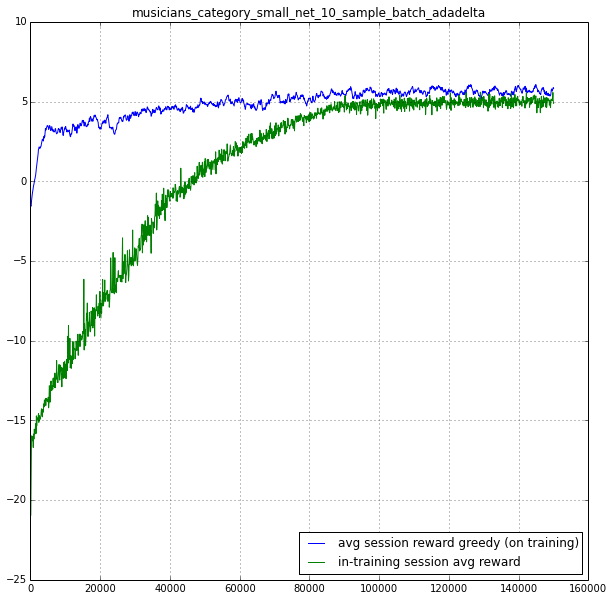

In [32]:
plot_scores(experiment_setup_name)

In [33]:
load_random_batch(env,train_attrs,train_cats,10)
print_session(10)

#166: decades_active:2000 (4.757) -> 1.0 | #25: last_activity:still_active (4.476) -> 1.0 | #26: decades_active:2010 (3.674) -> 1.0 | #260: decades_active:1990 (2.824) -> 1.0 | #149: Labels:is_known (2.504) -> -1.0 | #91: decades_active:1980 (2.771) -> 1.0 | #221: decades_active:1970 (1.930) -> 1.0 | #247: Website:is_known (1.999) -> 1.0 | #20: Instruments:vocals (0.981) -> 1.0 | #3: Instruments:guitar (0.263) -> -1.0 | #393: <end_session_action> (0.001) -> 0.0 | <end>
true: category:List_of_jazz_vocalists

#166: decades_active:2000 (4.757) -> 1.0 | #25: last_activity:still_active (4.476) -> 1.0 | #26: decades_active:2010 (3.674) -> 1.0 | #260: decades_active:1990 (2.824) -> 1.0 | #149: Labels:is_known (2.504) -> 1.0 | #247: Website:is_known (1.824) -> 1.0 | #1: Birth name:is_known (1.329) -> -1.0 | #20: Instruments:vocals (0.572) -> 1.0 | #3: Instruments:guitar (0.527) -> 1.0 | #393: <end_session_action> (0.000) -> 0.0 | <end>
true: category:List_of_female_rock_singers category:List_o

#9: Genres:electropop (3.460) -> -1.0 | #166: decades_active:2000 (4.739) -> 1.0 | #25: last_activity:still_active (4.495) -> 1.0 | #26: decades_active:2010 (3.695) -> 1.0 | #260: decades_active:1990 (2.822) -> 1.0 | #149: Labels:is_known (2.403) -> -1.0 | #91: decades_active:1980 (2.707) -> 1.0 | #221: decades_active:1970 (1.888) -> 1.0 | #247: Website:is_known (1.930) -> 1.0 | #20: Instruments:vocals (0.936) -> 1.0 | #3: Instruments:guitar (0.244) -> -1.0 | #393: <end_session_action> (0.002) -> 0.0 | <end>
true: category:List_of_jazz_vocalists


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


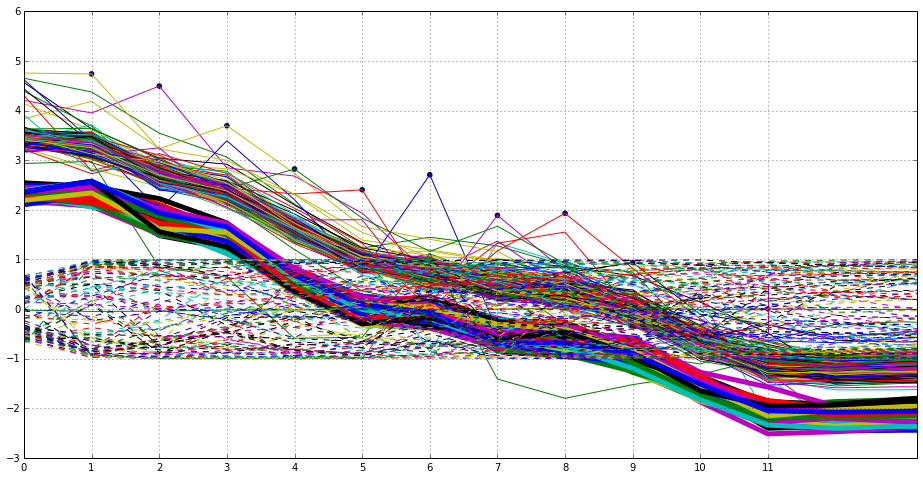


#166: decades_active:2000 (4.757) -> 1.0 | #25: last_activity:still_active (4.476) -> 1.0 | #26: decades_active:2010 (3.674) -> 1.0 | #260: decades_active:1990 (2.824) -> 1.0 | #149: Labels:is_known (2.504) -> 1.0 | #247: Website:is_known (1.824) -> 1.0 | #1: Birth name:is_known (1.329) -> -1.0 | #20: Instruments:vocals (0.572) -> 1.0 | #3: Instruments:guitar (0.527) -> 1.0 | #393: <end_session_action> (0.000) -> 0.0 | <end>
true: category:List_of_female_rock_singers category:List_of_all-female_bands


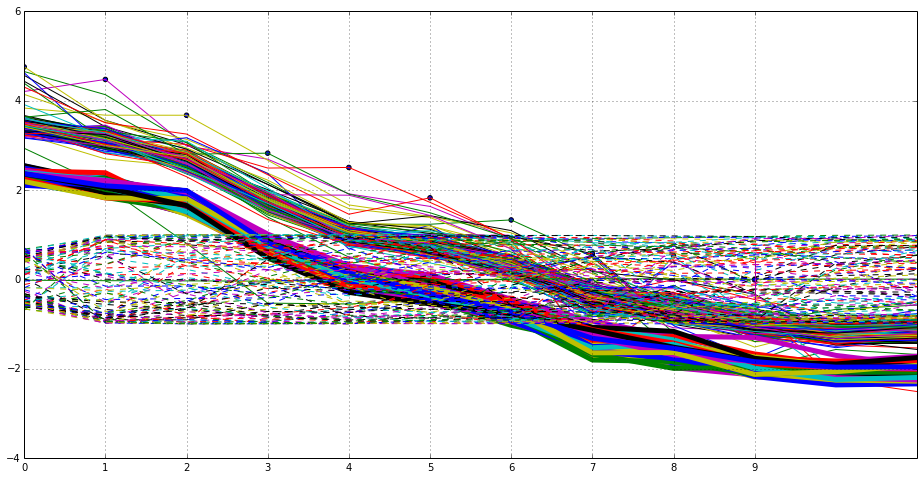


#166: decades_active:2000 (4.757) -> 1.0 | #25: last_activity:still_active (4.476) -> 1.0 | #26: decades_active:2010 (3.674) -> 1.0 | #260: decades_active:1990 (2.824) -> 1.0 | #149: Labels:is_known (2.504) -> 1.0 | #377: category:List_of_alternative_rock_artists (-0.345) -> -2.0 | #260: decades_active:1990 (1.671) -> 0.0 | #67: Genres:coast (0.367) -> -1.0 | #91: decades_active:1980 (1.939) -> 1.0 | #221: decades_active:1970 (1.555) -> -1.0 | #260: decades_active:1990 (0.347) -> 0.0 | #149: Labels:is_known (0.173) -> 0.0 | #393: <end_session_action> (-0.004) -> 0.0 | <end>
true: category:List_of_lead_guitarists category:List_of_guitarists


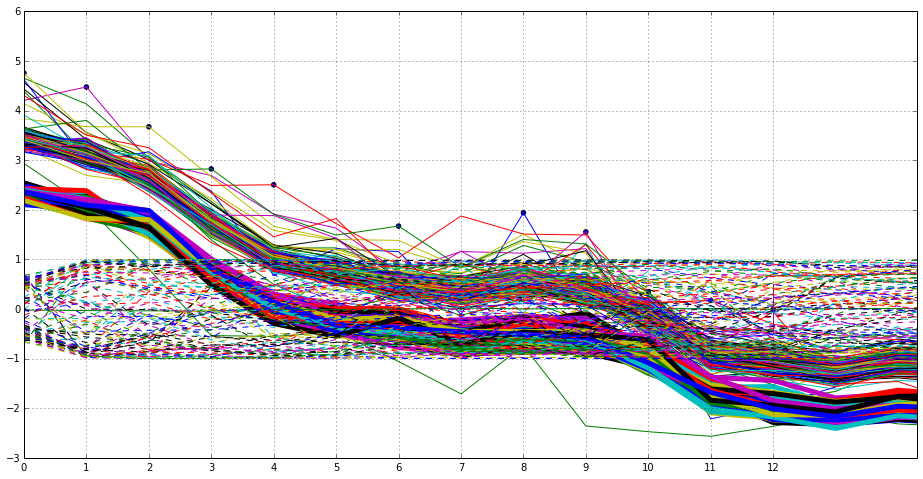

In [34]:
print_session(display=True,legend=False)